In [65]:
from pathlib import Path
import sys
sys.path.insert(0, str(Path().absolute().parent))

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics

from data.datasets import PureCompoundsInTallCuvettes, PureCompounds, COLOR_DICT
from data.data_functions import DataLoader, DerivTransform, NormalizeTransform
from data.experiment_parameters import (
        ExperimentFilter,
        Chamber, 
        Sensor, 
        InjectionTime, 
        InjectionRate, 
        InjectionVolume
)
from data.plot_functions import plot_array_data, get_gradient_colors, plot_regression
from data.utils import train_test_split, sort_by_set

SEED = 0

PROPERTIES = ['Boiling Point', 'Flash Point', 'Viscosity', 'Vapor Pressure']
MARKER_DICT = dict([('Pentane','o'), ('Hexane','s'), ('Heptane','D'), ('Octane','^'), ('Nonane','>'), ('Decane','v')])

#### Functions

In [114]:
from data.utils import create_label_for
from sklearn import datasets, svm, metrics
from sklearn.model_selection import GridSearchCV
    
unit = {"Vapor Pressure": " [kPa]",
        "Boiling Point": " [$^\circ$C]",
        "Flash Point": " [$^\circ$C]",
        "Viscosity": " [mPa$\cdot$s]"}

def predict_property(property_, train_set, train_derivs, kernel = 'rbf'):
    if property_ not in unit.keys():
        print('Property is ill-defined.')
        return
    
    # Change labels
    train_lbl = np.array(create_label_for(train_set, property_))
    
    # Perform SVR
    gridsearch = False

    if gridsearch == True:
        #------------------------------------------------------------#
        # SVR with gridsearch
        #------------------------------------------------------------#
        parameters = {'kernel':('linear', 'rbf'), 'C':(1e-10,1e-7,1e-5,1e-3,1,1e3,1e5,1e7,1e10), 'gamma':(1e-10,1e-7,1e-5,1e-3,1,1e3,1e5,1e7,1e10)}
        GS = svm.SVR()
        SVR = GridSearchCV(GS, parameters, cv=5)
    else:
        #------------------------------------------------------------#
        # SVR
        #------------------------------------------------------------#
        SVR = svm.SVR(C=1e4,gamma=1e1, kernel=kernel)

    SVR.fit(train_derivs, train_lbl)
    
    return SVR


def plot_property(ax, property_, SVR, test_set, test_derivs, train_set, train_derivs, label = 'Toluene prediction', color = 'r'):
    if property_ in ['Boiling Point', 'Flash Point']:
        adj_axes = 273.15
    elif property_ in ['Vapor Pressure', 'Viscosity']:
        adj_axes = 0
    else:
        print('Property is ill-defined.')
        return
    
    # Change labels
    train_lbl = np.array(create_label_for(train_set, property_))
    test_lbl = np.array(create_label_for(test_set, property_))
    
    # Calculate R^2 value
    predicted = SVR.predict(test_derivs)
    score = SVR.score(test_derivs, test_lbl)

    # Calculate RMS error
    actual = np.array(test_lbl).reshape(1,-1)
    predicted = np.array(predicted).reshape(1,-1)
    N = len(test_lbl)
    error = np.sqrt(np.sum((predicted-actual)**2)/N)
    
    ######## PLOT ########
    ax.set_xlabel('Actual '+property_+unit[property_], fontsize = 13)
    ax.set_ylabel('Predicted '+property_+unit[property_], fontsize = 13)
    ax.tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = 12)

    # plot line representing 1:1 correspondence
    ax.plot(np.linspace(np.min(np.append(train_lbl-adj_axes,0)),np.max(train_lbl-adj_axes),100),np.linspace(np.min(np.append(train_lbl-adj_axes,0)),np.max(train_lbl-adj_axes),100),'--',c='k',linewidth=1)
    
    if score > 0.5:
        # scatter predictions
        #ax.scatter(np.array(test_lbl-adj_axes),np.array(predicted-adj_axes),c=np.array([82/255., 157/255., 64/255.])*0.8,s=15, label = "Alkane prediction")
        for ind,lbl in enumerate([key for key,values in test_set.items() for value in values]):
            ax.scatter(np.array(test_lbl[ind]-adj_axes),np.array(predicted[0][ind]-adj_axes),c=(np.array([82/255., 157/255., 64/255.])*0.8).reshape(1,3),marker=MARKER_DICT[lbl],s=15, label = "Alkane prediction")

        # label
        ax.text(0.065,0.97, "$R^2$ = "+str(round(score,3)) + "\nRMSE = "+str(round(error,2)), fontsize=13, verticalalignment='top', transform = ax.transAxes)
    else:
        #ax.set_xlabel('Actual '+property_+unit[property_], fontsize = labelsize)
        fitted = SVR.predict(train_derivs)
        
        # scatter predictions
        ax.scatter(np.array(test_lbl-adj_axes),np.array(predicted-adj_axes),c=color, marker='o',s=15, label = label)

        # scatter training
        #ax.scatter(np.array(train_lbl-adj_axes),np.array(fitted-adj_axes),c='None', marker='s',s=20,edgecolors=(0, 0, 0), alpha=0.3,linewidths=0.5, label = "Alkane training") # previous edgecolor = (68/255., 114/255., 196/255.) with alpha = None
        for ind,lbl in enumerate([key for key,values in train_set.items() for value in values]):
            ax.scatter(np.array(train_lbl[ind]-adj_axes),np.array(fitted[ind]-adj_axes),c='None', marker=MARKER_DICT[lbl],s=20,edgecolors=(0, 0, 0), alpha=0.3,linewidths=0.5, label = "Alkane training")

        # label
        ax.text(0.065,0.955, "RMSE = "+str(round(np.sqrt(np.sum((predicted-actual)**2)/N),2)), fontsize=13, verticalalignment='top', transform = ax.transAxes)
        print(property_ + ': ' + str(np.mean(predicted-adj_axes).round(2)) + ' ± ' + str(round(np.sqrt(np.sum((predicted-actual)**2)/N),2)) + unit[property_])

    #plt.legend(loc="lower right", fontsize = 12, markerscale = 1.5)
    plt.tight_layout()
    
    #fig = plt.gcf()
    #plt.close()
    
    #return fig
    
def sig(x,n=2): # round to significant figures
    from math import log10, floor
    return round(x, n-1-int(floor(log10(abs(x)))))

def plot_feature_weight(SVR, property_, train_derivs = [], test_derivs = [], ax = plt):
    if train_derivs:
        max_ = np.max(train_derivs, axis = 0)
        min_ = np.min(train_derivs, axis = 0)
        
        ax.fill_between(np.linspace(0,len(max_)-1,len(max_)),max_,min_, color = 'k', alpha=0.1)
    if test_derivs:
        max_T = np.max(test_derivs, axis = 0)
        min_T = np.min(test_derivs, axis = 0)
        
        ax.fill_between(np.linspace(0,len(max_T)-1,len(max_T)),max_T,min_T, color = 'r', alpha=0.1)
    
    prod = np.matmul(SVR[property_].dual_coef_,SVR[property_].support_vectors_)
    weights = prod.T/np.sqrt(np.sum(prod.T**2))
    
    ax.set_xlabel('Time (s)', fontsize = 13)
    
    if np.max(weights) >= np.abs(np.min(weights)):
        ax.plot(weights);
        ax.set_ylabel('Feature weight$^*$', fontsize = 13)
    else:
        ax.plot(-weights);
        ax.set_ylabel('-Feature weight$^*$', fontsize = 13)

## Known analytes

In [67]:
exp_set = PureCompoundsInTallCuvettes()
exp_set = {chem:exp_set[chem] for chem in ['Pentane', 'Hexane','Heptane','Octane','Nonane','Decane']}

print(sum([len(vs) for vs in exp_set.values()]))
exp_set
# psi_derivs, labels = DataLoader(PureCompoundsInTallCuvettes(), transforms=[DerivTransform, NormalizeTransform]).load()

42


{'Pentane': [148, 174, 202, 203, 239, 240, 241, 434, 435],
 'Hexane': [175, 184, 185, 186, 187, 199, 204, 205, 424, 425],
 'Heptane': [150, 206, 207],
 'Octane': [151, 177, 208, 209, 242, 243, 244, 283],
 'Nonane': [152, 178, 188, 189, 267],
 'Decane': [153, 179, 190, 191, 197, 268, 284]}

In [68]:
filters = ExperimentFilter(Chamber.TALL, Sensor.SM30, InjectionTime(15.0), InjectionRate(6.0), InjectionVolume(1.3))
exp_set = PureCompounds(['Pentane', 'Hexane','Heptane','Octane','Nonane','Decane'], filters=filters)

print(sum([len(vs) for vs in exp_set.values()]))
exp_set

38


PureCompounds([('Pentane', [174, 239, 240, 241, 434, 435, 148]),
               ('Hexane', [199, 186, 204, 205, 175, 149, 184, 185, 282, 187]),
               ('Heptane', [150, 206, 207]),
               ('Octane', [208, 209, 242, 243, 244, 151, 283]),
               ('Nonane', [267, 178, 152, 188, 189]),
               ('Decane', [197, 268, 179, 153, 284, 191])])

Load dataset

In [69]:
exp_derivs, labels = DataLoader(exp_set, transforms=[DerivTransform, NormalizeTransform]).load()

train_set, test_set = train_test_split(exp_set, test_size = 1./5, seed=SEED)
train_derivs, train_lbl, test_derivs, test_lbl = sort_by_set(exp_derivs, train_set, test_set)

Loading experimental data
(1/6) Pentane (7 exp.): [===================0] 100% complete
(2/6) Hexane (10 exp.): [===================0] 100% complete
(3/6) Heptane (3 exp.): [===================0] 100% complete
(4/6) Octane (7 exp.): [===================0] 100% complete
(5/6) Nonane (5 exp.): [===================0] 100% complete
(6/6) Decane (6 exp.): [===================0] 100% complete
Length of experimental set loaded: 38


## Unknown analyte

In [70]:
toluene_set = PureCompounds(['Toluene'], filters=filters)

Load dataset

In [120]:
toluene_derivs, toluene_labels = DataLoader(toluene_set, transforms=[DerivTransform, NormalizeTransform]).load()

toluene_test_derivs, _ = sort_by_set(toluene_derivs, toluene_set)

Loading experimental data
(1/1) Toluene (7 exp.): [===================0] 100% complete
Length of experimental set loaded: 7


# Create Plot

Create SVRs

In [72]:
SVR = {}
#figA = {}

for property_ in PROPERTIES:
    SVR[property_] = predict_property(property_, train_set, train_derivs);
    #figA[property_] = plot_property(property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);

Boiling Point: 116.49 ± 9.44 [$^\circ$C]
Flash Point: 5.78 ± 4.82 [$^\circ$C]
Viscosity: 0.47 ± 0.09 [mPa$\cdot$s]
Vapor Pressure: 11.68 ± 9.0 [kPa]


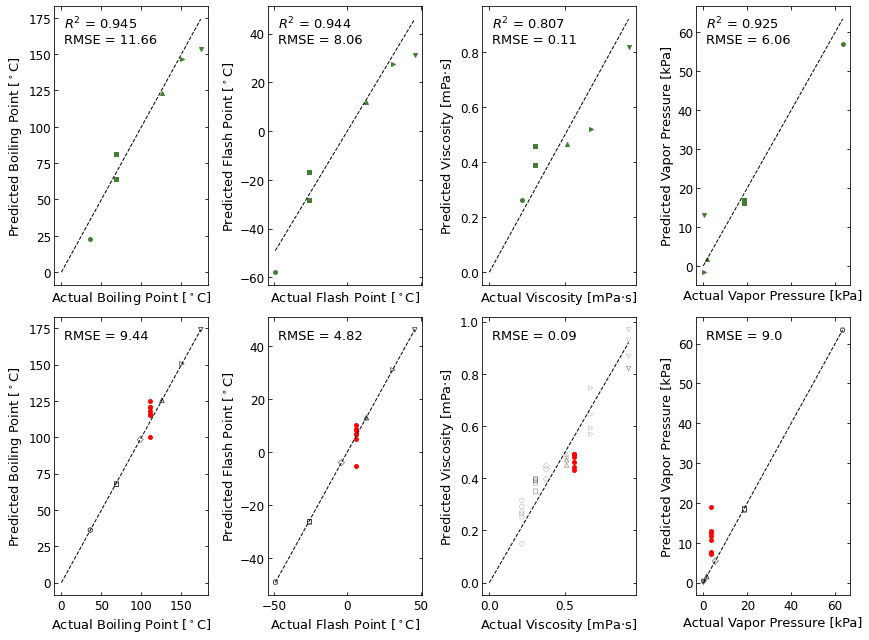

In [73]:
fig, ax = plt.subplots(2, len(SVR), sharex='col', sharey=False);
fig.set_figwidth(12)
fig.set_figheight(9)

for a, property_ in enumerate(PROPERTIES):
    plot_property(ax[0,a], property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);
    plot_property(ax[1,a], property_, SVR[property_], toluene_set, toluene_test_derivs, train_set, train_derivs);

for a in ax.flatten():
    if a.get_legend() != None:
        a.get_legend().remove()
    
#ax[0,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);
#ax[1,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);

# Supplementary figures

Supplementary figure for linear kernel

In [86]:
linSVR = {}
#figA = {}

for property_ in PROPERTIES:
    linSVR[property_] = predict_property(property_, train_set, train_derivs, kernel = 'linear');
    #figA[property_] = plot_property(property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);

Boiling Point: 64.44 ± 52.04 [$^\circ$C]
Flash Point: -28.97 ± 38.22 [$^\circ$C]
Viscosity: 0.37 ± 0.24 [mPa$\cdot$s]
Vapor Pressure: 33.75 ± 32.85 [kPa]


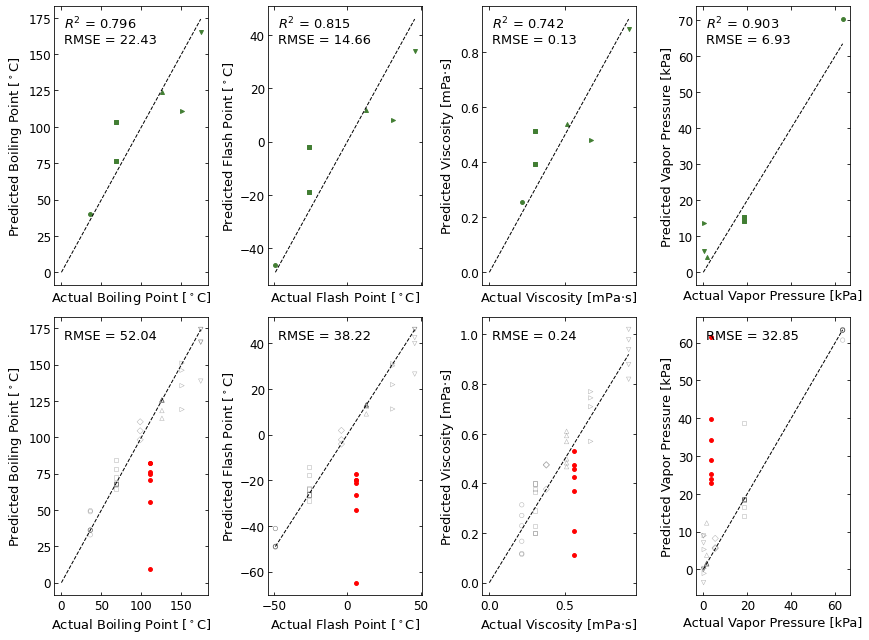

In [89]:
fig, ax = plt.subplots(2, len(SVR), sharex='col', sharey=False);
fig.set_figwidth(12)
fig.set_figheight(9)

for a, property_ in enumerate(PROPERTIES):
    plot_property(ax[0,a], property_, linSVR[property_], test_set, test_derivs, train_set, train_derivs)
    plot_property(ax[1,a], property_, linSVR[property_], toluene_set, toluene_test_derivs, train_set, train_derivs)

for a in ax.flatten():
    if a.get_legend() != None:
        a.get_legend().remove()

##### Supplementary feature weights

In [97]:
from collections import OrderedDict

all_derivs = dict([(key,value) for key,value in exp_derivs.items()])
for key, value in toluene_derivs.items():
    all_derivs[key] = value
all_set = OrderedDict([(key,value) for key,value in exp_set.items()])
for key, value in toluene_set.items():
    all_set[key] = value

In [101]:
def plot_array_data(exp_set, input_data, xlim, ylim=None, color_dict = None, legend=True, ax=None, linewidth = None, linestyle = '-', label = True):
    if ax == None:
        fig, ax = plt.subplots()
        
    for chem in exp_set:    
        nums = exp_set[chem]
        data = [input_data[n] for n in nums]

        # calculate average
        avg = np.average(data, axis = 0)
        std = np.std(data, axis = 0)
        
        try:
            ax.plot(np.linspace(xlim[0],xlim[1],len(avg)),avg, label = chem, linestyle = linestyle, linewidth = linewidth, color = color_dict[chem])
            ax.fill_between(np.linspace(xlim[0],xlim[1],len(avg)),np.array(avg) - np.array(std),np.array(avg) + np.array(std), color = color_dict[chem], alpha=0.1)
        except:
            ax.plot(np.linspace(xlim[0],xlim[1],len(avg)),avg, label = chem, color = None)
            ax.fill_between(np.linspace(xlim[0],xlim[1],len(avg)),np.array(avg) - np.array(std),np.array(avg) + np.array(std), alpha=0.1)
        if legend:
            if len(exp_set) > 8:
                ax.legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False, fontsize=12)
            else:
                ax.legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=1, frameon=False, shadow=False, fontsize=12)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    if label == True:
        if xlim[0] == 0:
            ax.set_xlabel("Time (s)", fontsize=13);
            ax.set_ylabel("Phase derivative (a.u.)", fontsize=13)
        else:
            ax.set_xlabel("Wavelength (nm)", fontsize=13)
            ax.set_ylabel("$\Delta I$ (a.u.)", fontsize=13)
        ax.tick_params(labelsize=12)
    else:
        ax.set_xticks = []

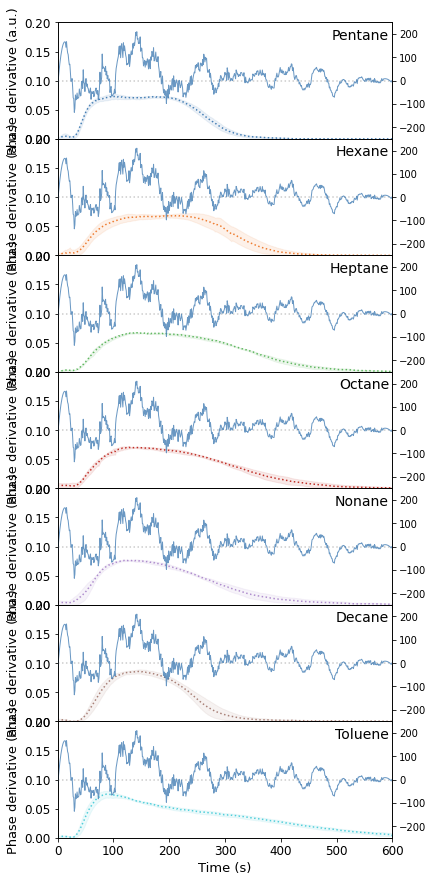

In [103]:
from data.datasets import COLOR_DICT as color_dict

fig,ax = plt.subplots(ncols = 1, nrows = len(all_set), sharex = True)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0)

property_ = 'Boiling Point'

for n,chem in enumerate(all_set):    
    ax2 = ax[n].twinx()
    ax2.set_ylim([-250,250])
    ax2.set_xlim([-25,625])
    ax2.plot([0,650],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
    ax2.plot(linSVR[property_].coef_[0], color=color_dict['Pentane'], alpha=0.8, linewidth=1)
    ax[n].text(0.99,0.95, chem, fontsize=14, verticalalignment='top', horizontalalignment = 'right', transform = ax[n].transAxes)
    
    subset = OrderedDict([list(all_set.items())[n]])
    plot_array_data(subset, all_derivs, [0,600], ylim=[0,0.2], color_dict = color_dict, ax=ax[n], linestyle = ':', linewidth = 1.5)
    ax[n].get_legend().remove()

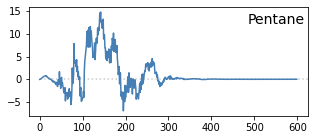

In [106]:
property_ = PROPERTIES[0]
p = 0

chem = 'Pentane'
n = 0

subset = OrderedDict([list(all_set.items())[n]])
data = [all_derivs[m] for m in list(subset.values())[0]]
avg = np.average(data, axis = 0) # calculate average

fig,ax = plt.subplots()

ax.set_xlim([-25,625])
ax.plot([0,625],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
ax.plot(linSVR[property_].coef_[0]*avg, color=color_dict[chem])
ax.text(0.99,0.95, chem, fontsize=14, verticalalignment='top', horizontalalignment = 'right', transform = ax.transAxes)
#ax[n].set_ylim([-0.4,1])

ax2.set_xlim([-25,625])
ax2.plot([0,625],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
if chem in ['Pentane','Hexane','Heptane']:
    ax2.scatter(np.linspace(0,600,600),linSVR[property_].coef_[0]*avg, s=0.5, color=color_dict[chem], label = chem)
elif chem in ['Toluene']:
    ax2.plot(linSVR[property_].coef_[0]*avg, color=color_dict[chem], label = chem)
ax2.legend(loc = 'lower right')

fig.set_size_inches([5,2])
# coloring in certain regions e.g. (BP,FP) [250, 350], (VP) [50, 100], (3) , and (concentration change in) [50, 250]
#ax.fill_between([50, 250],[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2, color = (0.7, 0.7, 0.7), alpha=0.1)

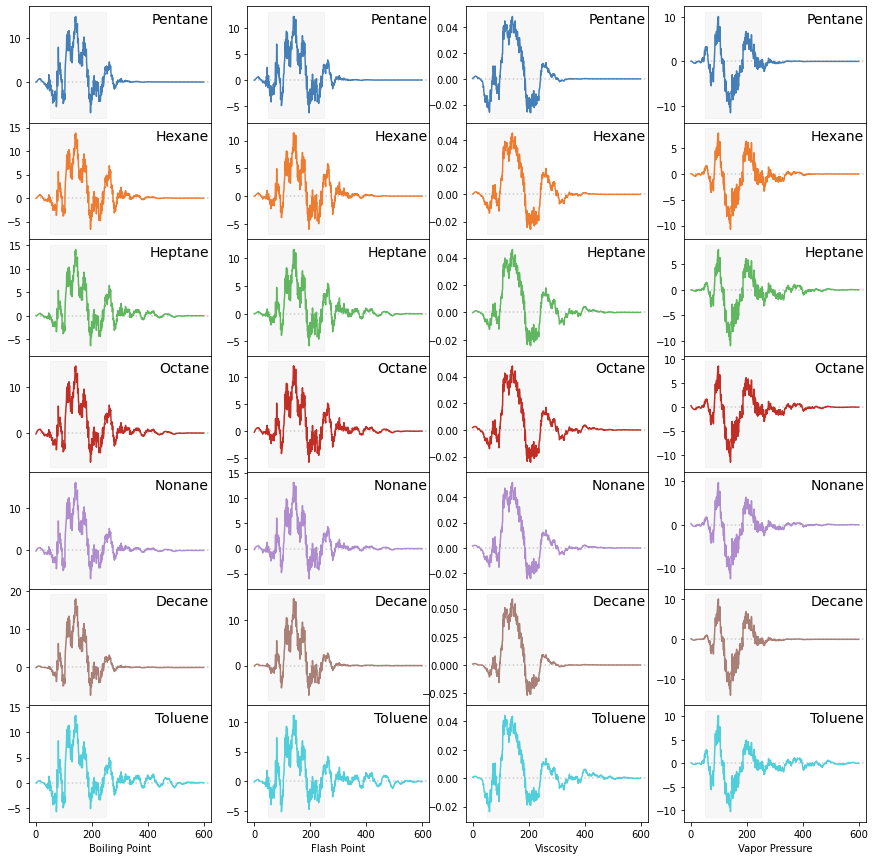

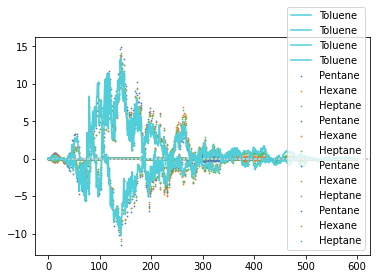

In [110]:
# plot multiplied feature coef_ and average phase derivative
fig,axes = plt.subplots(ncols = 4, nrows = len(all_set), sharex = True)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0)

fig2, ax2 = plt.subplots()

for p,property_ in enumerate(PROPERTIES):
    for n,chem in enumerate(all_set):
        subset = OrderedDict([list(all_set.items())[n]])
        data = [all_derivs[m] for m in list(subset.values())[0]]
        avg = np.average(data, axis = 0) # calculate average
        
        ax = axes[n,p]

        ax.set_xlim([-25,625])
        ax.plot([0,625],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
        ax.plot(linSVR[property_].coef_[0]*avg, color=color_dict[chem])
        ax.text(0.99,0.95, chem, fontsize=14, verticalalignment='top', horizontalalignment = 'right', transform = ax.transAxes)
        #ax[n].set_ylim([-0.4,1])

        ax2.set_xlim([-25,625])
        ax2.plot([0,625],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
        if chem in ['Pentane','Hexane','Heptane']:
            ax2.scatter(np.linspace(0,600,600),linSVR[property_].coef_[0]*avg, s=0.5, color=color_dict[chem], label = chem)
        elif chem in ['Toluene']:
            ax2.plot(linSVR[property_].coef_[0]*avg, color=color_dict[chem], label = chem)
        ax2.legend(loc = 'lower right')
        
        # coloring in certain regions e.g. (BP,FP) [250, 350], (VP) [50, 100], (3) , and (concentration change in) [50, 250]
        ax.fill_between([50, 250],[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2, color = (0.7, 0.7, 0.7), alpha=0.1)
    
    ax.set_xlabel(property_)
# fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Feature Weights - all.svg', dpi=1200)

## Feature Importance
for supplement potentially

linSVR = {}
#figA = {}

for property_ in PROPERTIES:
    linSVR[property_] = predict_property(property_, train_set, train_derivs, kernel='linear');
    #figA[property_] = plot_property(property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);

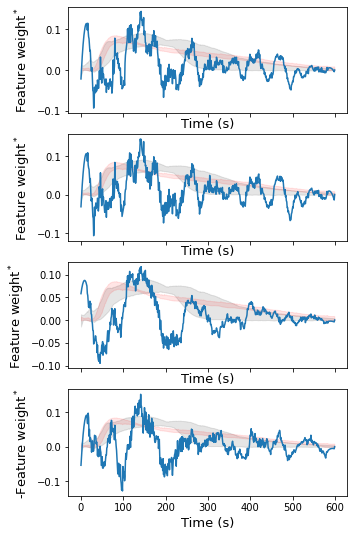

In [121]:
fig, ax = plt.subplots(len(PROPERTIES),1, sharex='col', sharey=False);
fig.set_figwidth(5)
fig.set_figheight(9)

for n,property_ in enumerate(PROPERTIES):
    plot_feature_weight(linSVR, property_, train_derivs=train_derivs, test_derivs=toluene_test_derivs, ax = ax[n])

In [21]:
# Plot using linear kernel

#fig, ax = plt.subplots(2, len(SVR), sharex='col', sharey=False);
#fig.set_figwidth(12)
#fig.set_figheight(9)
#
#for a, property_ in enumerate(properties):
#    plot_property(ax[0,a], property_, linSVR[property_], test_set, test_derivs, train_set, train_derivs);
#    plot_property(ax[1,a], property_, linSVR[property_], toluene_set, toluene_derivs, train_set, train_derivs);
#
#for a in ax.flatten():
#    if a.get_legend() != None:
#        a.get_legend().remove()
#    
#ax[0,0].legend(loc="lower right", fontsize = 12, markerscale = 1.5);
#ax[1,0].legend(loc="lower right", fontsize = 12, markerscale = 1.5);

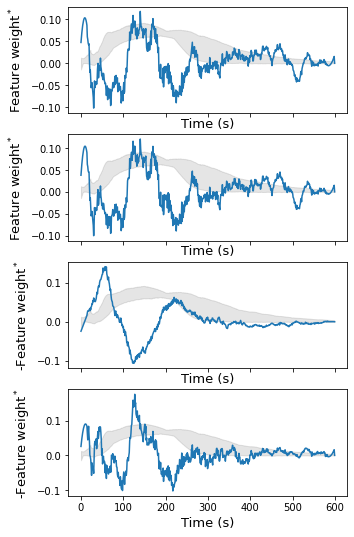

In [122]:
# Feature "weights" using RBF kernel (do not work the same way as in linear)

fig, ax = plt.subplots(len(PROPERTIES),1, sharex='col', sharey=False);
fig.set_figwidth(5)
fig.set_figheight(9)

for n,property_ in enumerate(PROPERTIES):
    plot_feature_weight(SVR, property_, train_derivs=train_derivs, ax = ax[n])

## Polar chemicals

In [123]:
# from data.datasets import pure_compounds, tall_Cuvettes, SM30_Sensors, injection_Time, injection_Rate, injection_Volume
# from data.datasets import train_test_split
#exp_set = pure_compounds(['Pentane', 'Hexane','Heptane','Octane','Nonane','Decane', 'Toluene'], in_ = tall_Cuvettes(), with_ = SM30_Sensors(), and_a = injection_Time([15.0]), and_b = injection_Rate(6.0), and_c = injection_Volume([1.3]))
#train_set = train_set #pure_compounds(['Pentane', 'Hexane','Heptane', 'Octane', 'Nonane','Decane'], in_ = tall_Cuvettes(), with_ = SM30_Sensors(), and_a = injection_Time([15.0]), and_b = injection_Rate(6.0), and_c = injection_Volume([1.3]))
polar_set = PureCompounds(['Ethanol','Acetone','Acetonitrile'], filters=filters)

In [125]:
polar_derivs, toluene_labels = DataLoader(polar_set, transforms=[DerivTransform, NormalizeTransform]).load()

polar_test_derivs, polar_lbl = sort_by_set(polar_derivs, polar_set)

Loading experimental data
(1/3) Ethanol (8 exp.): [===================0] 100% complete
(2/3) Acetone (8 exp.): [===================0] 100% complete
(3/3) Acetonitrile (7 exp.): [===================0] 100% complete
Length of experimental set loaded: 23


Boiling Point: 102.38 ± 25.01 [$^\circ$C]
Boiling Point: 72.33 ± 32.24 [$^\circ$C]
Boiling Point: 92.58 ± 13.36 [$^\circ$C]
Flash Point: -4.72 ± 19.21 [$^\circ$C]
Flash Point: -24.74 ± 19.4 [$^\circ$C]
Flash Point: -10.58 ± 13.57 [$^\circ$C]
Viscosity: 0.46 ± 0.63 [mPa$\cdot$s]
Viscosity: 0.36 ± 0.11 [mPa$\cdot$s]
Viscosity: 0.41 ± 0.08 [mPa$\cdot$s]
Vapor Pressure: 20.21 ± 13.25 [kPa]
Vapor Pressure: 40.34 ± 21.46 [kPa]
Vapor Pressure: 15.37 ± 7.14 [kPa]


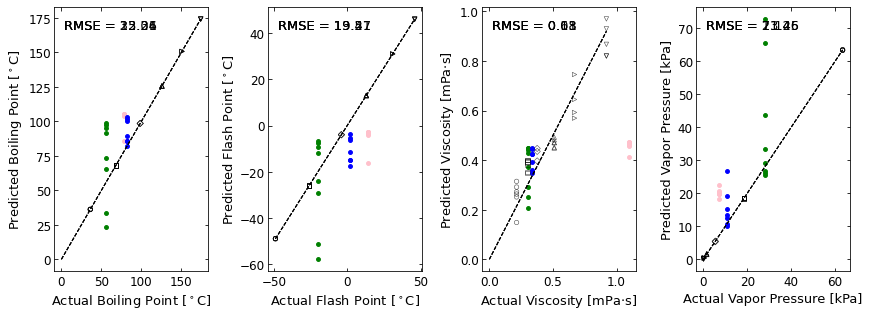

In [126]:
fig, ax = plt.subplots(1, len(SVR), sharex='col', sharey=False);
fig.set_figwidth(12)
fig.set_figheight(4.5)

colr = {'Ethanol': 'pink', 'Acetone': 'green', 'Acetonitrile': 'blue'}

for a, property_ in enumerate(PROPERTIES):
    for chem in polar_set:
        sub_polar = {chem:polar_set[chem]}
        sub_derivs = list(np.array(polar_test_derivs)[np.where(chem == np.array(polar_lbl))])
        plot_property(ax[a], property_, SVR[property_], sub_polar, sub_derivs, train_set, train_derivs, label = chem, color = colr[chem]);

for a in ax.flatten():
    if a.get_legend() != None:
        a.get_legend().remove()

#fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Predicting physical procerties - EtOH, Acetone, Acetonitrile.svg', dpi=1200)